In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
rcParams['font.size'] = 14

# This is optional, but it allows zooming and panning of figures
# Uncomment the block below if you want this feature

interactive = False # Set this to false if no iteractive data are desired.
if interactive:
    try:
        import mpld3
        from mpld3 import plugins
        mpld3.enable_notebook()
        print('Interactive plotting enabled')
    except:
        interactive = False

Populating the interactive namespace from numpy and matplotlib


# ReachPreProcessor Example

In this example, we demonstrate how to load a set of predefined reaches and process them so that they are better suited to the data and applications.

In this case, the reaches are from the North America Global River Width Database for Large Rivers. The data were made by [Tamlin Pavelsky](mailto:pavelsky@unc.edu) and [George Allen](mailto:georgehenryallen@gmail.com) and modified by [Ernesto Rodriguez](mailto:ernesto.rodriguez@jpl.nasa.gov) so that reaches appeared as topologically connected. The results are in the shapefile `nAmerica_GRWDL_river_topo.shp`. A rapidly searchable width database, segemented by reach has been made into a pytables hdf5 file and will be used as width data base.

As sample data for this data collection, we use some simulated SWOT data over the Sacrramento River.

In [3]:
import os
from os.path import exists, join
def find_riverobs_test_data_dir():
    """Fin the location of the test data root directory"""
    
    if 'RIVEROBS_TESTDATA_DIR' in os.environ:
        test_data_dir = os.environ('RIVEROBS_TESTDATA_DIR')
    else: # try the default location
        test_data_dir = '../../../RiverObsTestData'
        
    if not exists(test_data_dir):
        print('You must either set the environment variable RIVEROBS_TESTDATA_DIR')
        print('or locate the test data directory at ../../../RiverObsTestData')
        raise Exception('Test data directory not found.')
        
    return test_data_dir

data_dir = find_riverobs_test_data_dir()
data_dir

'../../../RiverObsTestData'

In [4]:
# This is the file for the width data base

db_dir = join(data_dir,'GRWDL')
width_db_file = join(db_dir,'nAmerica_GRWDL.h5')

# This is the SWOT data

l2_file = join(data_dir,'L2','L2v0','simulated_sacramento_swot_test_data_v0.nc')
assert exists(l2_file)

# This is the file for the reach data base

shape_file_root = join(db_dir,'nAmerica_GRWDL_river_topo','nAmerica_GRWDL_river_topo')

## Import the Required Modules and Initialize Objects

In [5]:
from SWOTRiver import SWOTL2
from RiverObs import ReachPreProcessor, RiverReachWriter

/Users/erodrigu/anaconda/envs/RiverObs/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Read the SWOT simulated data to find the data bounding box and define the projection function. For the editing function, use the true data classification and true water location.

In [6]:
class_list=[1]
lat_kwd='no_layover_latitude'
lon_kwd='no_layover_longitude'

l2 = SWOTL2(l2_file,class_list=class_list,lat_kwd=lat_kwd,lon_kwd=lon_kwd)

Cant Find range_index, or azimuth_index variables, assuming 2D-image image coordinates (like from a gdem)


Initialize the pre-processor with the GRWDL data. The next step scans through the database and finds all of the overlapping reaches in the data base (only one is found). A small buffer of about 2km is placed about the data bounding box to make sure the river is not cut.

In [7]:
clip_buffer = 0.02
reaches = ReachPreProcessor(shape_file_root, l2,clip_buffer=clip_buffer,width_db_file=width_db_file)

In [8]:
print('Number of reaches found:',reaches.nreaches)
print('Reach indexes:',reaches.reach_idx)
for i,reach in enumerate(reaches):
    print('Reach %d Metadata'%i)
    print(reach.metadata)

Number of reaches found: 1
Reach indexes: [704]
Reach 0 Metadata
{'latmax': 40.03200149536133, 'break_idx': 1388940, 'width_mean': 115.74655151367188, 'reach': 375745.03125, 'reach_idx': 704, 'width_max': 532.0, 'width_std': 52.802425384521484, 'width_min': 30.0, 'lonmin': -122.11900329589844, 'npoints': 10144, 'lonmax': -121.5009994506836, 'latmin': 38.16350173950195}


As a guide to editing the reaches, plot the data and reach locations for each reach found. 

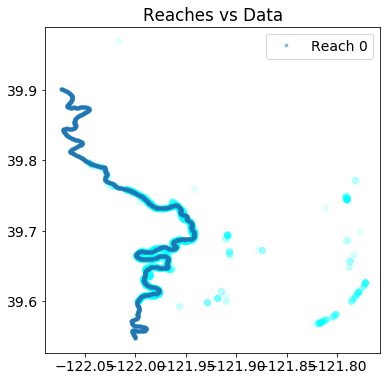

In [9]:
figsize(6,6)
plot(l2.lon[::10],l2.lat[::10],'o',alpha=0.1,color='aqua')
for reach in reaches:
    plot(reach.lon,reach.lat,'.',alpha=0.4,label='Reach %d'%i)
legend(loc='best')
title('Reaches vs Data')
if interactive:
    plugins.connect(gcf(),plugins.MousePosition(fmt='.3f'))

**Figure 1**: Clearly the reach is much longer than the bit of data imaged. We can cut it down in several way, as demonstrated in the following.

## Break reach by predefined points

Use interactive graphics in the iPython notebook to pick the location of the breaks.

In [10]:
start_lons = [-122.010,-121.965,-121.962,-121.978]
start_lats = [39.760,39.735,39.685,39.648]
end_lons = [-121.965,-121.962,-121.978,-121.998]
end_lats = [39.735,39.685,39.648,39.601]

reach_start_list = list(zip(start_lons,start_lats))
reach_end_list = list(zip(end_lons,end_lats))

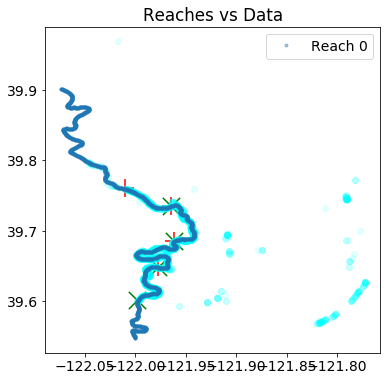

In [11]:
figsize(6,6)
plot(l2.lon[::10],l2.lat[::10],'o',alpha=0.1,color='aqua')
for reach in reaches:
    plot(reach.lon,reach.lat,'.',alpha=0.4,label='Reach %d'%i)
scatter(start_lons,start_lats,s=300,c='r',marker='+')
scatter(end_lons,end_lats,s=300,c='g',marker='x')
legend(loc='best')
title('Reaches vs Data')
if interactive:
    plugins.connect(gcf(),plugins.MousePosition(fmt='.3f'))

In [12]:
edited_reaches = reaches.split_by_coordinates(reach_start_list,reach_end_list)

In [13]:
for reach in edited_reaches:
    print(reach.metadata)

OrderedDict([('reach_idx', 0), ('lonmin', -122.01000213623051), ('lonmax', -121.96499633789061), ('latmin', 39.731700890249243), ('latmax', 39.759498589237268), ('reach', 6639.4358592689023), ('npoints', 142), ('break_idx', 141), ('preach_idx', 0), ('pstart_s', 27671.332707718801), ('pend_s', 34310.768566987703), ('pidxstart', 641), ('pidxend', 782), ('width_mean', 152.21830985915494), ('width_max', 258), ('width_min', 60), ('width_std', 44.661814706951525)])
OrderedDict([('reach_idx', 1), ('lonmin', -121.96499633789061), ('lonmax', -121.94200134277338), ('latmin', 39.685001366300874), ('latmax', 39.736198418327533), ('reach', 9459.6523086880406), ('npoints', 236), ('break_idx', 377), ('preach_idx', 0), ('pstart_s', 34310.768566987703), ('pend_s', 43770.420875675743), ('pidxstart', 782), ('pidxend', 1017), ('width_mean', 133.30084745762713), ('width_max', 379), ('width_min', 42), ('width_std', 52.415373271722665)])
OrderedDict([('reach_idx', 2), ('lonmin', -121.99900054931641), ('lonma

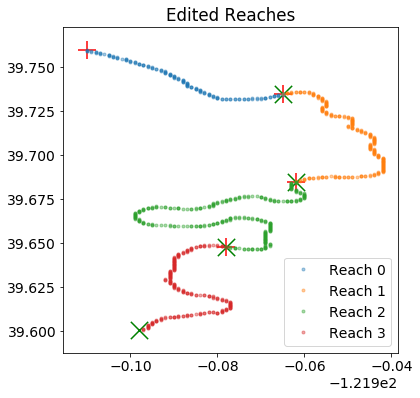

In [14]:
figsize(6,6)
for i,reach in enumerate(edited_reaches):
    plot(reach.lon,reach.lat,'.',alpha=0.4,label='Reach %d'%i)
scatter(start_lons,start_lats,s=300,c='r',marker='+')
scatter(end_lons,end_lats,s=300,c='g',marker='x')
legend(loc='best')
title('Edited Reaches')
if interactive:
    plugins.connect(gcf(),plugins.MousePosition(fmt='.3f'));

## Break reach by constant reach length

One possible way to break the reaches, which is not particularly sensible from a hydrologic perspective, is to break the reaches into sections of equal lengtgh. This process is demonstarted below:

In [15]:
start_s = 25.e3
ds = 10.e3
end_s = start_s + 4*ds
edited_reaches = reaches.split_by_reach_length(ds,start_s=start_s,end_s=end_s)

In [16]:
for reach in edited_reaches:
    print(reach.metadata)

OrderedDict([('reach_idx', 0), ('lonmin', -122.02899932861331), ('lonmax', -121.95899963378912), ('latmin', 39.731700890249243), ('latmax', 39.770999901498683), ('reach', 9935.3353558792951), ('npoints', 217), ('break_idx', 216), ('preach_idx', 0), ('pstart_s', 25054.055977183009), ('pend_s', 34989.391333062304), ('pidxstart', 582), ('pidxend', 798), ('width_mean', 143.09216589861751), ('width_max', 258), ('width_min', 60)])
OrderedDict([('reach_idx', 1), ('lonmin', -121.96299743652341), ('lonmax', -121.94200134277338), ('latmin', 39.676399223962711), ('latmax', 39.735298149772468), ('reach', 9889.7441916725729), ('npoints', 251), ('break_idx', 467), ('preach_idx', 0), ('pstart_s', 35077.958664585014), ('pend_s', 44967.702856257587), ('pidxstart', 799), ('pidxend', 1049), ('width_mean', 140.17529880478088), ('width_max', 381), ('width_min', 42)])
OrderedDict([('reach_idx', 2), ('lonmin', -121.99900054931641), ('lonmax', -121.9599990844727), ('latmin', 39.652400963452969), ('latmax', 39

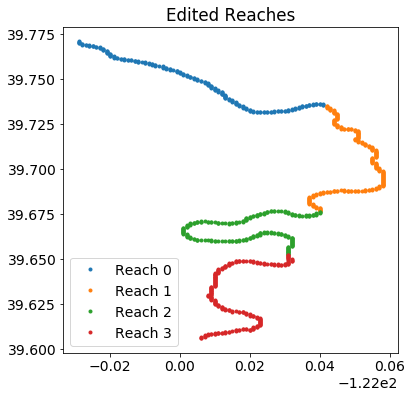

In [17]:
figsize(6,6)
for i,reach in enumerate(edited_reaches):
    plot(reach.lon,reach.lat,'.',alpha=1,label='Reach %d'%i)
legend(loc='best')
title('Edited Reaches')
if interactive:
    plugins.connect(gcf(),plugins.MousePosition(fmt='.3f'));

## Output the edited reaches and width data base

Once the reaches are edited, the results can be written to a new OGR supported data format. The default format is "ESRI Shapefile", which is the format expected by the ReachExtractor class. Also, if desired, output the width data base in hdf5 pytables format.

First, initialize the RiverReachWriter:

In [18]:
node_output_name = 'edited_nodes'
reach_output_name = 'edited_reaches'


!rm -rf $node_output_name
!rm -rf $reach_output_name

node_output_variables = ['width']
reach_output_variables = edited_reaches[0].metadata.keys()
reach_writer = RiverReachWriter(edited_reaches,node_output_variables,reach_output_variables)

First, write as node shape files as Point data with dbf fields for each point:

In [19]:
reach_writer.write_nodes_ogr(node_output_name)

Write the reach data as LineString shapefiles:

In [20]:
reach_writer.write_reaches_ogr(reach_output_name)

Just to show that it can be done, and for visualization, write them also as KML:

In [21]:
reach_writer.write_nodes_ogr(node_output_name+'.kml',driver='KML')
reach_writer.write_reaches_ogr(reach_output_name+'.kml',driver='KML')
!ls *.kml

edited_nodes.kml   edited_reaches.kml


Finally, one can write a new width data base, if one was provided to begin width.

In [22]:
width_db_file = 'edited_width_db'
river_df, reach_df = reach_writer.write_width_db(width_db_file,output_format='h5')
!ls *.h5

edited_width_db.h5


In [23]:
print(reach_df.head())

   break_idx     latmax     latmin      lonmax      lonmin  npoints  \
0        216  39.771000  39.731701 -121.959000 -122.028999      217   
1        467  39.735298  39.676399 -121.942001 -121.962997      251   
2        690  39.676601  39.652401 -121.959999 -121.999001      223   
3        928  39.652100  39.605900 -121.968002 -121.994003      238   

         reach  width_max  width_mean  width_min  width_std  
0  9964.823242        258  143.092166         60  43.281426  
1  9964.823242        381  140.175299         42  60.407259  
2  9964.823242        296  139.493274         60  51.019461  
3  9964.823242        270  134.831933         60  37.838516  


In [24]:
print(river_df.head())

   width  nchannels  reservoir        long        lat  reach_index       reach
0    108          1          0 -122.028999  39.771000            0   22.024439
1     67          1          0 -122.028999  39.770802            0   55.484642
2     67          1          0 -122.028999  39.770500            0   88.944847
3    127          1          0 -122.028999  39.770199            0  121.981506
4     84          1          0 -122.028999  39.769901            0  210.507629


In [25]:
print(river_df.tail())

     width  nchannels  reservoir        long        lat  reach_index  \
924     84          1          0 -121.992996  39.606899            3   
925     84          1          0 -121.992996  39.606701            3   
926    108          1          0 -121.994003  39.606400            3   
927    108          1          0 -121.994003  39.606098            3   
928     67          1          0 -121.994003  39.605900            3   

           reach  
924  9816.604492  
925  9909.340820  
926  9942.799805  
927  9964.823242  
928  9964.823242  
